In [1]:
import torch_geometric.transforms as T
import os.path as osp
from sklearn.manifold import TSNE
import torch
import umap

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import random
from scipy.integrate import simps
from matplotlib import cm
from matplotlib.patches import Ellipse
import seaborn as sns
from scipy.spatial.distance import cdist
from numpy.linalg import LinAlgError
import re

2024-09-20 10:16:20.785376: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-20 10:16:20.899140: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-20 10:16:20.909876: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-20 10:16:20.909900: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

Read in data

In [2]:
window = 60 * 60

day_1_start = (8 * 60 + 30) * 60
day_1_end = (17 * 60 + 30) * 60
day_2_start = ((24 + 8) * 60 + 30) * 60
day_2_end = ((24 + 17) * 60 + 30) * 60

T1 = int((day_1_end - day_1_start) // window)
T2 = int((day_2_end - day_2_start) // window)
T = T1 + T2

print(f"Number of time windows: {T}")

# %%
fname = "ia-primary-school-proximity-attr.edges"
file = open(fname)

label_dict = {
    "1A": 0,
    "1B": 1,
    "2A": 2,
    "2B": 3,
    "3A": 4,
    "3B": 5,
    "4A": 6,
    "4B": 7,
    "5A": 8,
    "5B": 9,
    "Teachers": 10,
}
num_classes = 10

nodes = []
node_labels = []
edge_tuples = []

for line in file:
    node_i, node_j, time, id_i, id_j = line.strip("\n").split(",")

    if day_1_start <= int(time) < day_1_end:
        t = (int(time) - day_1_start) // window
    elif day_2_start <= int(time) < day_2_end:
        t = T1 + (int(time) - day_2_start) // window
    else:
        continue

    if node_i not in nodes:
        nodes.append(node_i)
        node_labels.append(label_dict[id_i])

    if node_j not in nodes:
        nodes.append(node_j)
        node_labels.append(label_dict[id_j])

    edge_tuples.append([t, node_i, node_j])

edge_tuples = np.unique(edge_tuples, axis=0)
nodes = np.array(nodes)

n = len(nodes)
print(f"Number of nodes: {n}")

node_dict = dict(zip(nodes[np.argsort(node_labels)], range(n)))
node_labels = np.sort(node_labels)

# %% [markdown]
# Create a list of adjacency matrices.

# %%
As = np.zeros((T, n, n))

for m in range(len(edge_tuples)):
    t, i, j = edge_tuples[m]
    As[int(t), node_dict[i], node_dict[j]] = 1
    As[int(t), node_dict[j], node_dict[i]] = 1

Number of time windows: 18
Number of nodes: 242


In [3]:
# Format the data to work with existing code
labels = node_labels

# just look at first (whatever is specified) timepoint
dense_adj = As[1]

Define functions for notebook

In [4]:
def compute_area_above_below_curve(x, y):
    area_above = 0.0
    area_below = 0.0
    
    for i in range(1, len(x)):
        x0, x1 = x[i - 1], x[i]
        y0, y1 = y[i - 1], y[i]
        line0, line1 = x0, x1  # Since line y = x
        
        if y1 == y0:  # Vertical segment
            if y0 > x0:
                area_above += (y0 - x0) * (x1 - x0)
            else:
                area_below += (x0 - y0) * (x1 - x0)
            continue
        
        # Find intersection with y = x
        if (y0 >= x0 and y1 >= x1) or (y0 <= x0 and y1 <= x1):
            if y0 >= x0 and y1 >= x1:
                area_above += 0.5 * (y0 + y1 - x0 - x1) * (x1 - x0)
            else:
                area_below += 0.5 * (x0 + x1 - y0 - y1) * (x1 - x0)
        else:
            x_intersect = x0 + (x0 - y0) * (x1 - x0) / (y1 - y0)
            if y0 < x0:
                area_below += 0.5 * (x0 - y0) * (x_intersect - x0)
                area_above += 0.5 * (y1 - x1) * (x1 - x_intersect)
            else:
                area_above += 0.5 * (y0 - x0) * (x_intersect - x0)
                area_below += 0.5 * (x1 - y1) * (x1 - x_intersect)
    
    return area_above, area_below


def plot_ellipse(ax, mean, cov, color):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigenvalues[:2])
    ellipse = Ellipse(mean, width, height, angle, edgecolor=color, facecolor='none', lw=2, label=f'Covariance Ellipse ({color})')
    ax.add_patch(ellipse)


# TO AVOID SINGULAR MATRIX ERROR
def points_within_ellipse(points, mean, cov, regularization=1e-32):
    try:
        # Attempt to calculate the inverse of the covariance matrix
        inv_cov = np.linalg.inv(cov)
    except LinAlgError:
        # If the matrix is singular, regularize and retry
        cov += np.eye(cov.shape[0]) * regularization
        inv_cov = np.linalg.inv(cov)
    
    # Calculate the Mahalanobis distance from the mean
    diff = points - mean
    mahalanobis_distances = np.sum(diff @ inv_cov * diff, axis=1)
    
    # Points within the ellipse have a Mahalanobis distance <= 1
    return mahalanobis_distances <= 1


In [5]:
k = 2

100%|██████████| 20/20 [00:03<00:00,  5.46it/s]


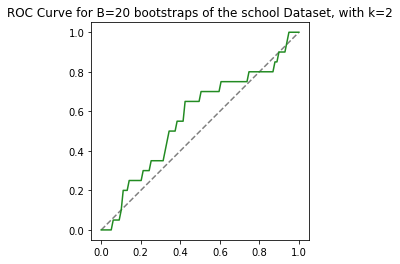

Total area (above and below y=x): 0.08287228988177871 for k=2


In [6]:
# obs_adj is the observed adjacency matrix
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

B = 20
d = 12

p_vals = []
A_boots_list = []

for b in tqdm(range(B)):
    p_val, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
    p_vals.append(p_val)
    A_boots_list.append(A_boots)

# Provided code
p_hat_list = p_vals
roc = []
alphas = []

for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]

plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title(f"ROC Curve for B={B} bootstraps of the school Dataset, with k={k}")
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

# Calculate the area between ROC and y=x line
x = np.linspace(0, 1, 100)
roc_interpolated = np.interp(x, alphas, roc)

# Compute areas
area_above, area_below = compute_area_above_below_curve(x, roc_interpolated)
total_area = area_above + area_below

print(f"Total area (above and below y=x): {total_area} for k={k}")

In [7]:
A_list = [dense_adj] + A_boots_list
len(A_list)

yhat = UASE(A_list, d=d, sparse_matrix=False)

In [8]:
yadf = pd.DataFrame(yhat)

# rename the columns - this is called a list comprehension
yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

# repeats tau list the len of A_true_boots_list times
yadf["tau"] = np.tile(node_labels, B + 1)


# add column for the matrix it is
yadf["Matrix"] = np.repeat(range(B+1), len(labels))

# repeat range(len(node_labels)) B+1 times to give each node a unique number
yadf['NodeNumber'] = list(range(len(node_labels)))*(B+1)

### Try different perplexity values in TSNE

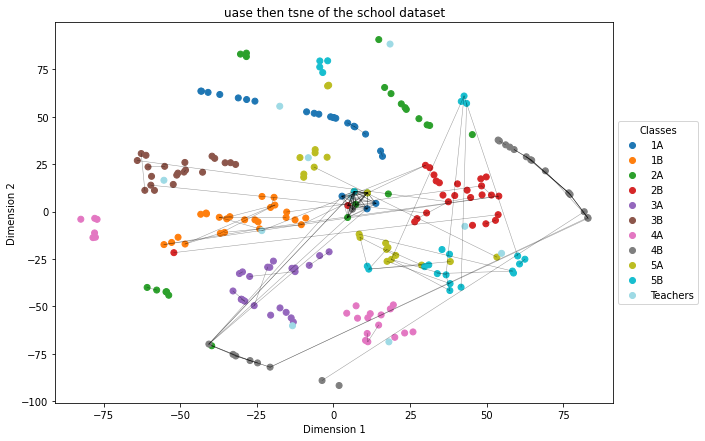

In [9]:
# tsne this embedding
perp_val = 30
tsne = TSNE(n_components=2, perplexity=perp_val, random_state=0)
yhat_tsne = tsne.fit_transform(yhat)


yhat_tsne_df = pd.DataFrame(yhat_tsne)
# rename the columns
yhat_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(yhat_tsne_df.shape[1])] 
# add column for the matrix it is
yhat_tsne_df["Matrix"] = np.repeat(range(B+1), len(node_labels))
# repeats tau list the len of A_true_boots_list times
yhat_tsne_df["tau"] = np.tile(node_labels, B+1)

yhat_tsne_df0 = yhat_tsne_df[yhat_tsne_df["Matrix"] == 0]
yhat_tsne_df1 = yhat_tsne_df[yhat_tsne_df["Matrix"] == 1]



""""create this weird new adjacency matrix"""
in_cov_friends = np.zeros((n,n))

for i in range(n):
    # Filter data for node number and select the relevant dimensions
    node_number = i
    data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

    # Calculate the mean and covariance considering all d dimensions
    mean_d_dim = np.mean(data_d_dim, axis=0)
    cov_d_dim = np.cov(data_d_dim, rowvar=False)

    # Use the point corresponding to the specific node_number in matrix 0 as the center
    point = data_d_dim[0]
    obs_points = yadf[yadf["Matrix"] == 0].iloc[:, 0:d].to_numpy()

    # Plotting only the first two dimensions
    data_2d = data_d_dim[:, 0:2]
    obs_points_2d = obs_points[:, 0:2]

    # Filter points within the ellipse
    inside_ellipse = points_within_ellipse(obs_points_2d, point[:2], cov_d_dim[:2, :2])

    # Extract node numbers for points inside the ellipse
    node_numbers_inside_ellipse = yadf[yadf["Matrix"] == 0].iloc[inside_ellipse].index.tolist()

    # # Print the node numbers within the ellipse if there are lots
    # if (len(node_numbers_inside_ellipse) > 20):
        # print(f"Node numbers within the ellipse centered at node {node_number}: {node_numbers_inside_ellipse}")

    # set in_cov_friends[i, node_numbers_inside_ellipse] = 1
    in_cov_friends[i, node_numbers_inside_ellipse] = 1


    # symmetrize the matrix in_cov_friends - 
# minimum means both must be 1
# maximum means at least one must be 1
in_cov_friends_symm = np.minimum(in_cov_friends, in_cov_friends.T)
# sns.heatmap(in_cov_friends_symm, square=True)


# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 7))

# Plot the first df
scatter = ax1.scatter(yhat_tsne_df0["Dimension_1"], yhat_tsne_df0["Dimension_2"], c=yhat_tsne_df0["tau"], cmap='tab20')
ax1.set_title("uase then tsne of the school dataset")
ax1.set_xlabel("Dimension 1")
ax1.set_ylabel("Dimension 2")

# Draw lines between connected nodes based on the adjacency matrix
for i in range(len(yhat_tsne_df0)):
    for j in range(i + 1, len(yhat_tsne_df0)):
        if in_cov_friends_symm[i, j] == 1:  # Check if nodes i and j are connected
            ax1.plot([yhat_tsne_df0["Dimension_1"].iloc[i], yhat_tsne_df0["Dimension_1"].iloc[j]], 
                     [yhat_tsne_df0["Dimension_2"].iloc[i], yhat_tsne_df0["Dimension_2"].iloc[j]], 
                     'k-', lw=0.5,alpha=0.4)  # Draw a line between them


# # Add legend for classes - 0 to 10 labels
# plt.legend(*scatter.legend_elements(), title="Classes", loc="center left", bbox_to_anchor=(1, 0.5))


# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels = scatter.legend_elements()
# Invert the label_dict to map integers back to class names
label_dict_inv = {v: k for k, v in label_dict.items()}  
# Convert the labels back to their integer form, handling LaTeX formatting
mapped_labels = []
for label in labels:
    # Extract the numeric part using regex
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))  # Extract the integer from the label
        mapped_labels.append(label_dict_inv[numeric_label])  # Map to class name using the inverted dictionary
# Update the legend with the mapped labels
plt.legend(handles, mapped_labels, title="Classes", loc="center left", bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

### Different perplexity values

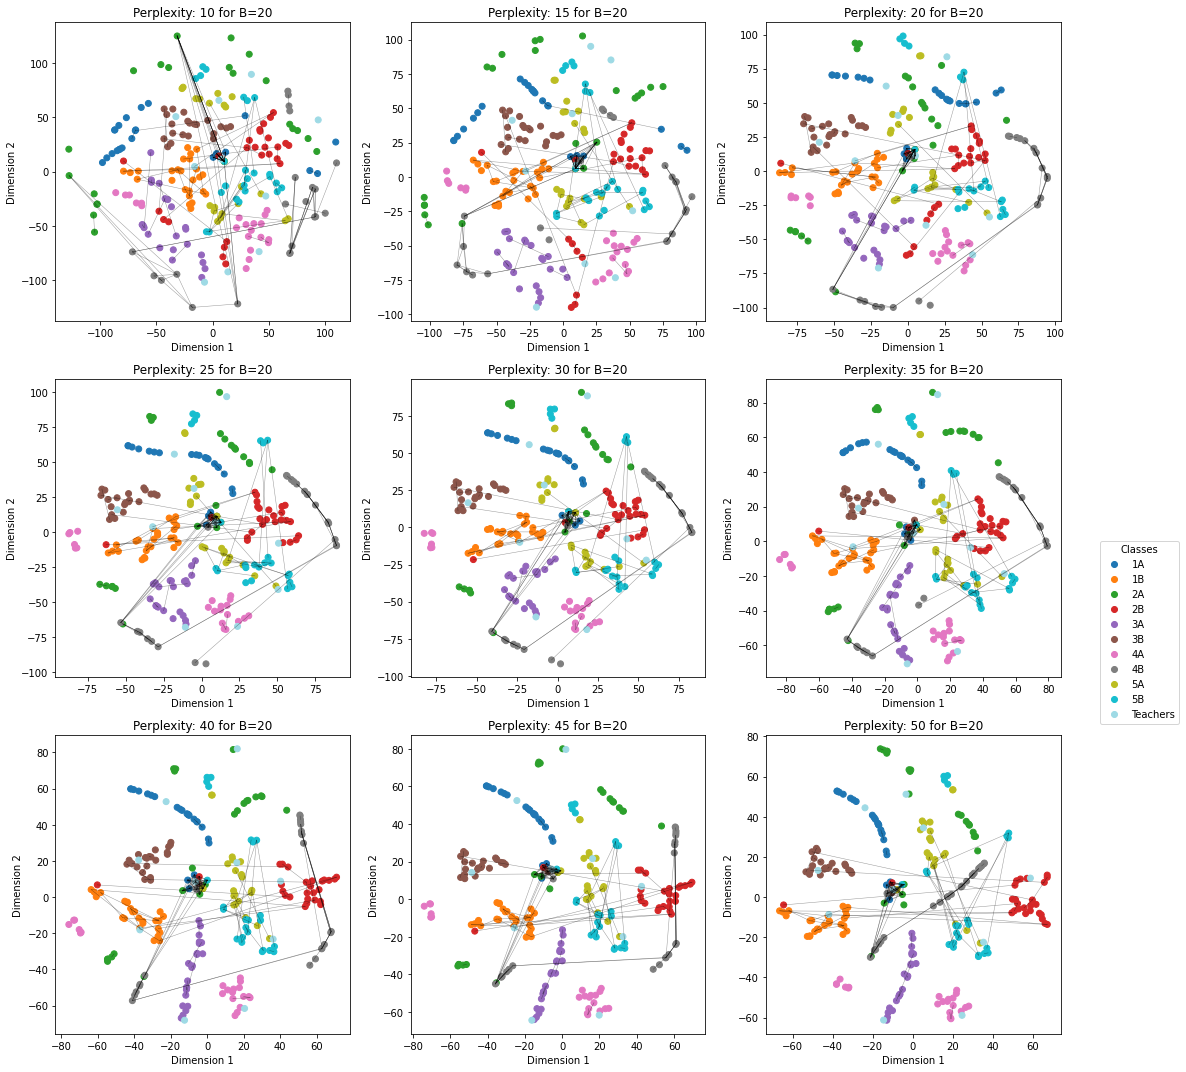

In [10]:
B = 20

# Define the list of perplexity values
perp_values = [10, 15, 20, 25, 30, 35, 40, 45, 50]

# Set up the 3x3 subplot grid
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Iterate over the perplexity values and subplot indices
for idx, perp_val in enumerate(perp_values):
    # Create the t-SNE embedding
    tsne = TSNE(n_components=2, perplexity=perp_val, random_state=0)
    yhat_tsne = tsne.fit_transform(yhat)

    # Convert to DataFrame
    yhat_tsne_df = pd.DataFrame(yhat_tsne)
    yhat_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(yhat_tsne_df.shape[1])]
    yhat_tsne_df["Matrix"] = np.repeat(range(B+1), len(node_labels))
    yhat_tsne_df["tau"] = np.tile(node_labels, B + 1)

    yhat_tsne_df0 = yhat_tsne_df[yhat_tsne_df["Matrix"] == 0]

    # Select the subplot
    ax = axs[idx // 3, idx % 3]

    # Plot the scatter plot
    scatter = ax.scatter(yhat_tsne_df0["Dimension_1"], yhat_tsne_df0["Dimension_2"], c=yhat_tsne_df0["tau"], cmap='tab20')
    ax.set_title(f"Perplexity: {perp_val} for B={B}")
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")

    # Draw lines between connected nodes based on the adjacency matrix
    for i in range(len(yhat_tsne_df0)):
        for j in range(i + 1, len(yhat_tsne_df0)):
            if in_cov_friends_symm[i, j] == 1:  # Check if nodes i and j are connected
                ax.plot([yhat_tsne_df0["Dimension_1"].iloc[i], yhat_tsne_df0["Dimension_1"].iloc[j]], 
                        [yhat_tsne_df0["Dimension_2"].iloc[i], yhat_tsne_df0["Dimension_2"].iloc[j]], 
                        'k-', lw=0.5, alpha=0.4)  # Draw a line between them

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv[numeric_label])
fig.legend(handles, mapped_labels, title="Classes", loc="upper right", bbox_to_anchor=(1.1, 0.5))

# Adjust layout to make room for titles and labels
plt.tight_layout()

# plt.savefig("schoolA0_tsne_perplexity_B20.png", facecolor='white')

# Show the combined plot
plt.show()

### Fix perplexity and change B

100%|██████████| 50/50 [00:02<00:00, 16.72it/s]


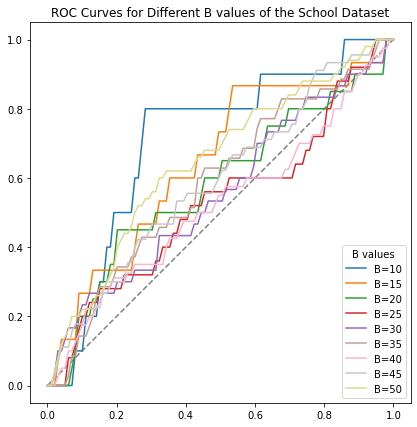

In [115]:
# Set random seeds for reproducibility
random.seed(100)
np.random.seed(100)

# Get the tab20 color palette for 10 distinct colors
colors = cm.get_cmap('tab20', 10)

# Parameters
d = 12
k = 2
B_values = range(10, 51, 5)

# Initialize lists to store ROC curves and areas
roc_curves_list = []
areas_list = []
alphas = np.linspace(0, 1, 100)

for B in B_values:
    p_vals = []
    A_boots_list = []

    # Generate bootstraps and calculate p-values
    for b in tqdm(range(B)):
        p_val, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
        p_vals.append(p_val)
        A_boots_list.append(A_boots)

    # Provided code
    p_hat_list = np.array(p_vals)
    roc = []

    for alpha in alphas:
        num_below_alpha = sum(p_hat_list < alpha)
        roc_point = num_below_alpha / len(p_hat_list)
        roc.append(roc_point)

    # Interpolate ROC for plotting
    roc_interpolated = np.interp(alphas, alphas, roc)
    roc_curves_list.append((B, roc_interpolated))

    # Calculate the area between ROC and y=x line
    x = np.linspace(0, 1, 100)
    area_above, area_below = compute_area_above_below_curve(x, roc_interpolated)
    total_area = area_above + area_below
    areas_list.append((B, total_area))

# Plot all ROC curves for different B values on the same plot
plt.figure(figsize=(10, 7))

# Plot y=x line
plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")

# Plot each ROC curve with a different color
for idx, (B, roc) in enumerate(roc_curves_list):
    plt.plot(alphas, roc, color=colors(idx), label=f'B={B}')

# Set title, aspect ratio, and legend
plt.title("ROC Curves for Different B values of the School Dataset")
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(title="B values", loc="lower right")

plt.savefig("roc_curves_school_dataA0_B.png", facecolor='white')

# Show the plot
plt.show()


100%|██████████| 50/50 [00:04<00:00, 10.56it/s]


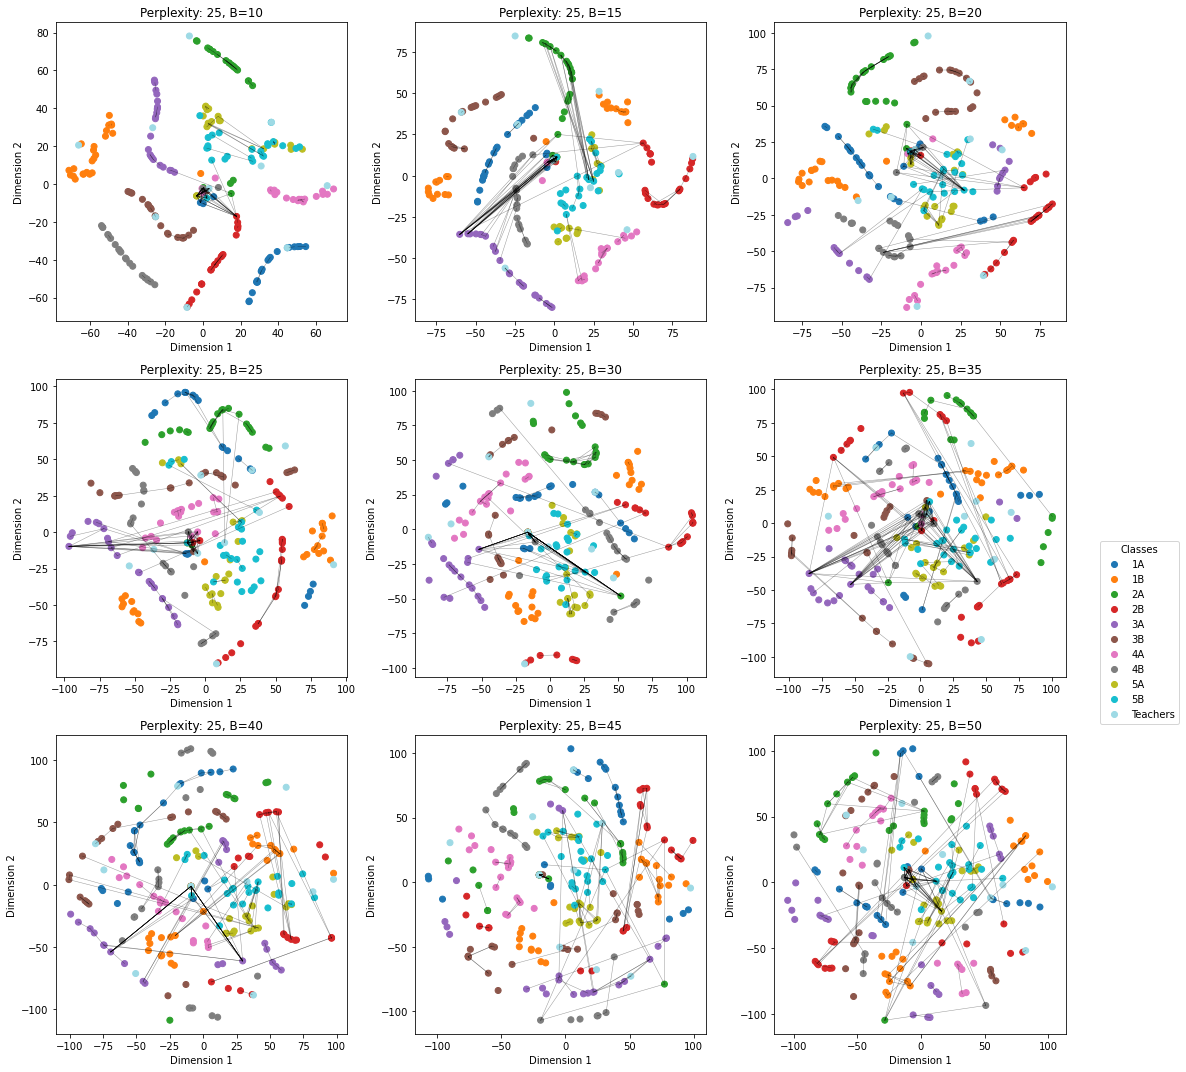

In [145]:
# Example setup for perplexity
perp_val = 25

# Assume B_values and other required variables like 'yhat', 'node_labels', 'in_cov_friends_symm' are already defined.
B_values = range(10, 51, 5)  # Example B values

# Set up the 3x3 subplot grid
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Iterate over B values with an index
for idx, B in enumerate(B_values):

    A_boots_list = []

    for b in tqdm(range(B)):
        _, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
        A_boots_list.append(A_boots)

    A_list = [dense_adj] + A_boots_list
    yhat = UASE(A_list, d=d, sparse_matrix=False)

    yadf = pd.DataFrame(yhat)

    # rename the columns - this is called a list comprehension
    yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

    # repeats tau list the len of A_true_boots_list times
    yadf["tau"] = np.tile(node_labels, B + 1)

    # add column for the matrix it is
    yadf["Matrix"] = np.repeat(range(B+1), len(node_labels))

    # repeat range(len(node_labels)) B+1 times to give each node a unique number
    yadf['NodeNumber'] = list(range(len(node_labels)))*(B+1)


    """"create this weird new uncertainty adjacency matrix using this many B bootstraps"""
    in_cov_friends = np.zeros((n,n))

    for i in range(n):
        # Filter data for node number and select the relevant dimensions
        node_number = i
        data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

        # Calculate the mean and covariance considering all d dimensions
        mean_d_dim = np.mean(data_d_dim, axis=0)
        cov_d_dim = np.cov(data_d_dim, rowvar=False)

        # Use the point corresponding to the specific node_number in matrix 0 as the center
        point = data_d_dim[0]
        obs_points = yadf[yadf["Matrix"] == 0].iloc[:, 0:d].to_numpy()

        # Plotting only the first two dimensions
        data_2d = data_d_dim[:, 0:2]
        obs_points_2d = obs_points[:, 0:2]

        # Filter points within the ellipse
        inside_ellipse = points_within_ellipse(obs_points_2d, point[:2], cov_d_dim[:2, :2])

        # Extract node numbers for points inside the ellipse
        node_numbers_inside_ellipse = yadf[yadf["Matrix"] == 0].iloc[inside_ellipse].index.tolist()

        # set in_cov_friends[i, node_numbers_inside_ellipse] = 1
        in_cov_friends[i, node_numbers_inside_ellipse] = 1

        # symmetrize the matrix in_cov_friends - 
    # minimum means both must be 1
    # maximum means at least one must be 1
    in_cov_friends_symm = np.minimum(in_cov_friends, in_cov_friends.T)
    # sns.heatmap(in_cov_friends_symm, square=True)



    # Create the t-SNE embedding
    tsne = TSNE(n_components=2, perplexity=perp_val, random_state=0)
    yhat_tsne = tsne.fit_transform(yhat)

    # Convert to DataFrame
    yhat_tsne_df = pd.DataFrame(yhat_tsne)
    yhat_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(yhat_tsne_df.shape[1])]
    yhat_tsne_df["Matrix"] = np.repeat(range(B + 1), len(node_labels))
    yhat_tsne_df["tau"] = np.tile(node_labels, B + 1)

    yhat_tsne_df0 = yhat_tsne_df[yhat_tsne_df["Matrix"] == 0]


    # Select the subplot
    ax = axs[idx // 3, idx % 3]

    # Plot the scatter plot
    scatter = ax.scatter(yhat_tsne_df0["Dimension_1"], yhat_tsne_df0["Dimension_2"], c=yhat_tsne_df0["tau"], cmap='tab20')
    ax.set_title(f"Perplexity: {perp_val}, B={B}")  # Now this will correctly reflect B
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")

    # Draw lines between connected nodes based on the adjacency matrix
    for i in range(len(yhat_tsne_df0)):
        for j in range(i + 1, len(yhat_tsne_df0)):
            if in_cov_friends_symm[i, j] == 1:  # Check if nodes i and j are connected
                ax.plot([yhat_tsne_df0["Dimension_1"].iloc[i], yhat_tsne_df0["Dimension_1"].iloc[j]], 
                        [yhat_tsne_df0["Dimension_2"].iloc[i], yhat_tsne_df0["Dimension_2"].iloc[j]], 
                        'k-', lw=0.5, alpha=0.4)  # Draw a line between them

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv[numeric_label])
fig.legend(handles, mapped_labels, title="Classes", loc="upper right", bbox_to_anchor=(1.1, 0.5))

# Adjust layout to make room for titles and labels
plt.tight_layout()

plt.savefig("school_A0_tsne_perp25_B.png", bbox_inches='tight', facecolor='white')

# Show the combined plot
plt.show()


### 15AUg2024 EMAIL RESPONSES

#### Embed the raw data by UMAP and tSNE

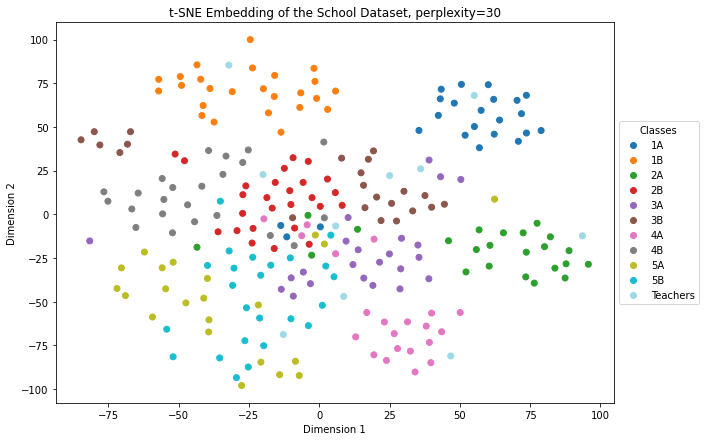

In [131]:
# embed dense_adj via tSNE
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
yhat_tsne = tsne.fit_transform(dense_adj)

# Convert to DataFrame
yhat_tsne_df = pd.DataFrame(yhat_tsne)
yhat_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(yhat_tsne_df.shape[1])]
yhat_tsne_df["tau"] = node_labels

# Plot the scatter plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(yhat_tsne_df["Dimension_1"], yhat_tsne_df["Dimension_2"], c=yhat_tsne_df["tau"], cmap='tab20')
plt.title("t-SNE Embedding of the School Dataset, perplexity=30")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}
mapped_labels = []

for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv[numeric_label])
    
plt.legend(handles, mapped_labels, title="Classes", loc="center left", bbox_to_anchor=(1, 0.5))

plt.savefig("school_A0_tsne_perplexity30.png", bbox_inches='tight', facecolor='white')
plt.show()

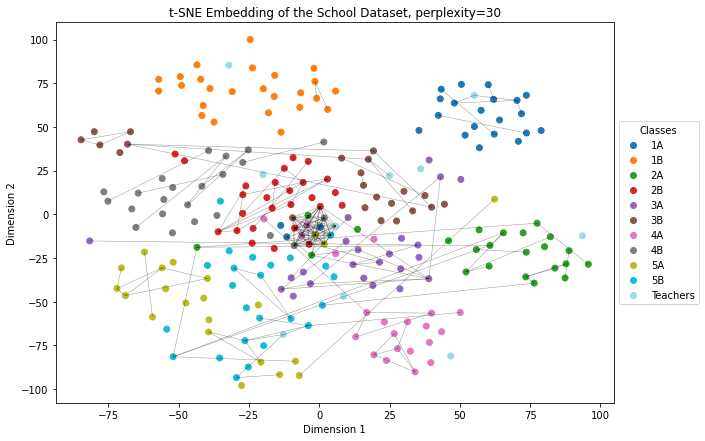

In [144]:
# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 7))

# Plot the scatter plot
scatter = ax1.scatter(yhat_tsne_df["Dimension_1"], yhat_tsne_df["Dimension_2"], 
                      c=yhat_tsne_df["tau"], cmap='tab20')
ax1.set_title("t-SNE Embedding of the School Dataset, perplexity=30")
ax1.set_xlabel("Dimension 1")
ax1.set_ylabel("Dimension 2")

# Draw lines between connected nodes based on the adjacency matrix
for i in range(len(yhat_tsne_df)):
    for j in range(i + 1, len(yhat_tsne_df)):
        if in_cov_friends_symm[i, j] == 1:  # Check if nodes i and j are connected
            ax1.plot([yhat_tsne_df["Dimension_1"].iloc[i], yhat_tsne_df["Dimension_1"].iloc[j]], 
                     [yhat_tsne_df["Dimension_2"].iloc[i], yhat_tsne_df["Dimension_2"].iloc[j]], 
                     'k-', lw=0.5, alpha=0.4)  # Draw a line between them

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}
mapped_labels = []

for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv[numeric_label])

ax1.legend(handles, mapped_labels, title="Classes", loc="center left", bbox_to_anchor=(1, 0.5))

# Save or show the plot
plt.savefig("school_A0_tsne_perplexity30_lines.png", bbox_inches='tight', facecolor='white')
plt.show()

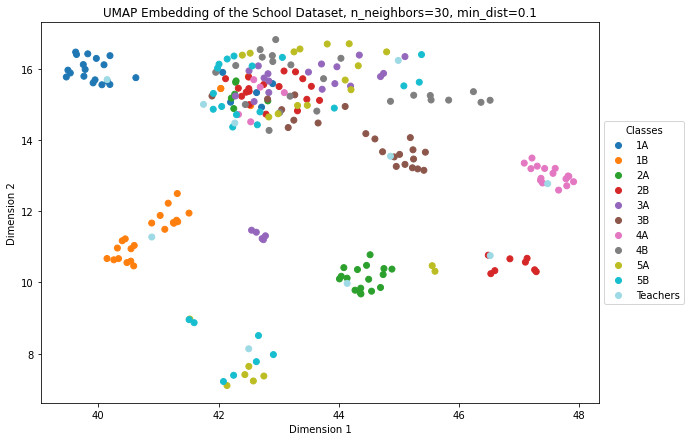

In [130]:
# embed dense_adj via UMAP
import umap
umap = umap.UMAP(n_components=2, random_state=0, n_neighbors=30, min_dist=0.1)
yhat_umap = umap.fit_transform(dense_adj)

# Convert to DataFrame
yhat_umap_df = pd.DataFrame(yhat_umap)
yhat_umap_df.columns = ["Dimension_{}".format(i+1) for i in range(yhat_umap_df.shape[1])]
yhat_umap_df["tau"] = node_labels

# Plot the scatter plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(yhat_umap_df["Dimension_1"], yhat_umap_df["Dimension_2"], c=yhat_umap_df["tau"], cmap='tab20')
plt.title("UMAP Embedding of the School Dataset, n_neighbors=30, min_dist=0.1")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}
mapped_labels = []

for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv[numeric_label])

plt.legend(handles, mapped_labels, title="Classes", loc="center left", bbox_to_anchor=(1, 0.5))

plt.savefig("school_A0_umap_30neighbors.png", bbox_inches='tight', facecolor='white')
plt.show()

### Check the LEFT $\hat{X}$ embedding rather than just the $\hat{Y}$ that comes from the observed matrix

In [132]:
k = 2

Create 20 bootstraps

In [133]:
# obs_adj is the observed adjacency matrix
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

B = 20
d = 12

p_vals = []
A_boots_list = []

for b in tqdm(range(B)):
    p_val, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
    p_vals.append(p_val)
    A_boots_list.append(A_boots)

100%|██████████| 20/20 [00:00<00:00, 21.82it/s]


In [134]:
A_list = [dense_adj] + A_boots_list
len(A_list)

21

In [135]:
xhat, yhat = UASE(A_list, d=d, sparse_matrix=False, return_left=True)

In [138]:
xadf = pd.DataFrame(xhat)

# rename the columns 
xadf.columns = ["Dimension_{}".format(i+1) for i in range(xadf.shape[1])]

# community label
xadf["tau"] = (labels.tolist())

# give each node a unique number
xadf['NodeNumber'] = list(range(len(node_labels)))

tSNE of xhat

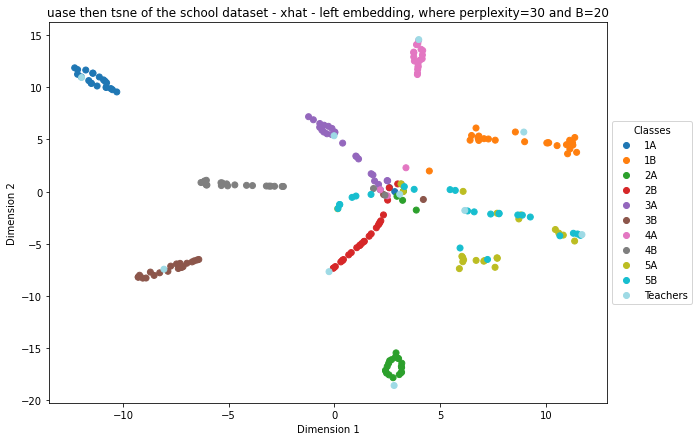

In [141]:
# tsne this embedding
perp_val = 30
tsne = TSNE(n_components=2, perplexity=perp_val, random_state=0)
xhat_tsne = tsne.fit_transform(xhat)


xhat_tsne_df = pd.DataFrame(xhat_tsne)
# rename the columns
xhat_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(xhat_tsne_df.shape[1])] 
# repeats tau list of community
xhat_tsne_df["tau"] = np.tile(node_labels, 1)


# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 7))

# Plot the first df
scatter = ax1.scatter(xhat_tsne_df["Dimension_1"], xhat_tsne_df["Dimension_2"], c=xhat_tsne_df["tau"], cmap='tab20')
ax1.set_title(f"uase then tsne of the school dataset - xhat - left embedding, where perplexity={perp_val} and B={B}")
ax1.set_xlabel("Dimension 1")
ax1.set_ylabel("Dimension 2")

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels = scatter.legend_elements()
# Invert the label_dict to map integers back to class names
label_dict_inv = {v: k for k, v in label_dict.items()}  
# Convert the labels back to their integer form, handling LaTeX formatting
mapped_labels = []
for label in labels:
    # Extract the numeric part using regex
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))  # Extract the integer from the label
        mapped_labels.append(label_dict_inv[numeric_label])  # Map to class name using the inverted dictionary
# Update the legend with the mapped labels
plt.legend(handles, mapped_labels, title="Classes", loc="center left", bbox_to_anchor=(1, 0.5))

plt.savefig("school_A0_uase_tsne_xhat_perplexity30_B20.png", facecolor='white')

# Show the plot
plt.show()